# Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models, layers, regularizers

In [3]:
import kagglehub

# Download latest version
path = r"C:\Users\HP\.cache\kagglehub\datasets\nirmalsankalana\sugarcane-leaf-disease-dataset\versions\1"

print("Path to dataset files:", path)

Path to dataset files: C:\Users\HP\.cache\kagglehub\datasets\nirmalsankalana\sugarcane-leaf-disease-dataset\versions\1


In [4]:
import os

# Use an absolute path with a raw string to handle backslashes correctly
directory = os.path.expanduser(path)


In [5]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=30

# Data Preprocessing

# Training Image preprocessing

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )

Found 2521 files belonging to 5 classes.


# Validation Image Preprocessing

In [10]:
class_names=dataset.class_names
class_names

['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

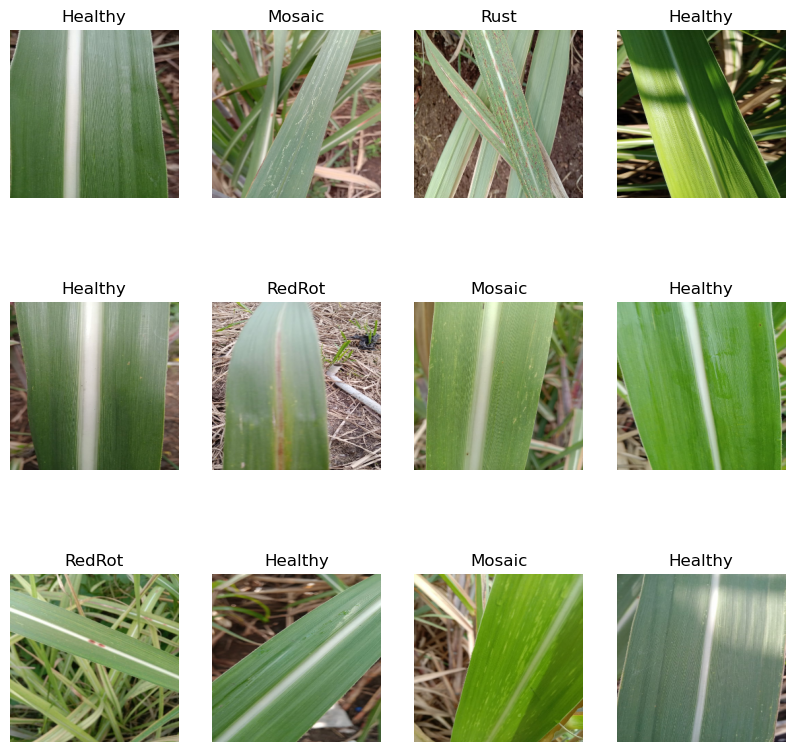

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

79

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

63

In [16]:
len(val_ds)

7

In [17]:
len(test_ds)

9

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
   layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
   
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Lower dropout rate

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
   
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Reduced dropout rate

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Moderate dropout

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
   
    layers.Dropout(0.3),  # Reduced dropout before output

    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,453 (3.42 MB)

 Trainable params: 896,453 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.2186 - loss: 1.7119 - val_accuracy: 0.2188 - val_loss: 1.6072
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.1935 - loss: 1.6063 - val_accuracy: 0.3348 - val_loss: 1.5076
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.3488 - loss: 1.4875 - val_accuracy: 0.3884 - val_loss: 1.3889
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.4297 - loss: 1.3367 - val_accuracy: 0.5357 - val_loss: 1.3347
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.4745 - loss: 1.2411 - val_accuracy: 0.5179 - val_loss: 1.2939
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1132s 18s/step - accuracy: 0.5683 - loss: 1.1088 - val_accuracy: 0.6250 - val_loss: 0.9612
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.6326 - loss: 0.9553 - val_accuracy: 0.6607 - val_loss: 0.8710
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.6892 - loss: 0.7852 - val_accuracy: 0.7321 - val_l

In [25]:
scores=model.evaluate(test_ds)
    

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.9253 - loss: 0.2840


In [26]:
scores

[0.27355650067329407, 0.9270833134651184]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 63}

In [29]:
type(history.history['loss'])

list

In [30]:
len(history.history['loss'])

30

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

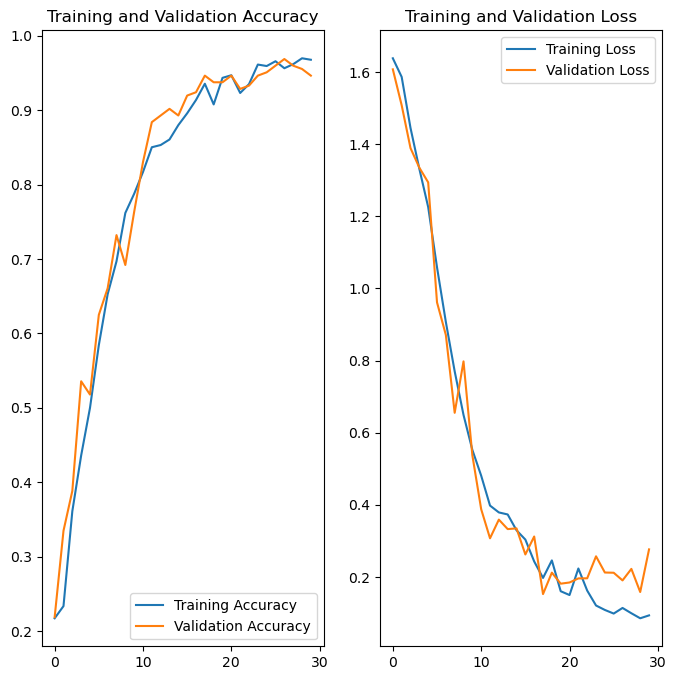

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Yellow
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
predicted label: Yellow


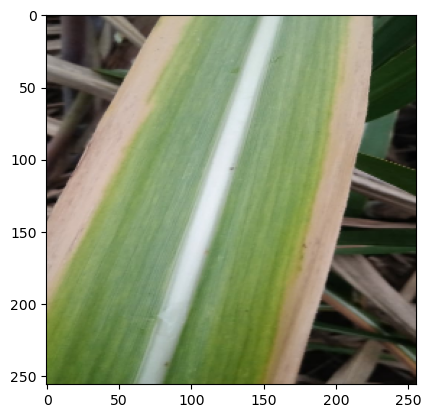

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


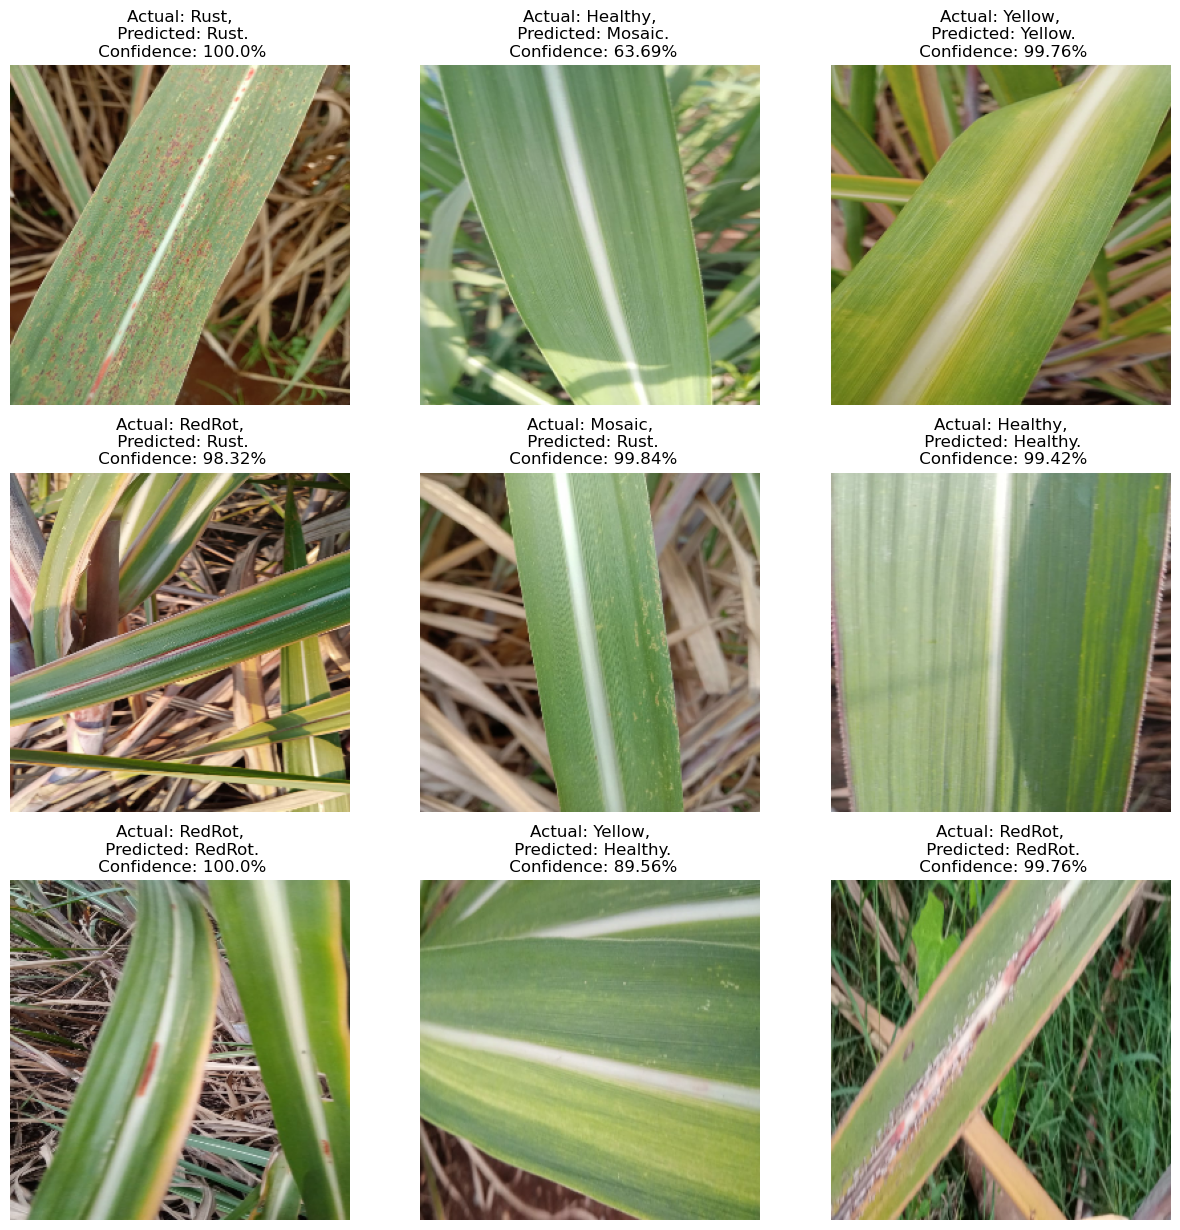

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

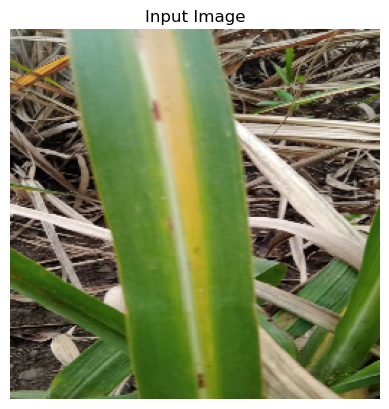

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Predicted Class: 4


In [73]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = r"C:\Users\HP\.cache\kagglehub\datasets\nirmalsankalana\sugarcane-leaf-disease-dataset\versions\1\Yellow\yellow (1).jpeg"
image = load_img(image_path, target_size=(256, 256)) 
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")
plt.show()

image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0) 


predictions = model.predict(image_array)
predicted_class = np.argmax(predictions, axis=1) 

print(f"Predicted Class: {predicted_class[0]}")